In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots
using JLD2

In [6]:
function run_bp(N::Integer; generic::Bool=false,
        tol = 1e-5)
    T = 10
    λ = 0.2
    ρ = 0.1
    γ = fill(0.05, N)

    sis = SIS(IndexedGraph(star_graph(N)), λ, ρ, T; γ)

    # set up MPBP computation
    bp_ = mpbp(sis)
    
    bp = if generic 
        mpbp(bp_.g, [GenericFactor.(wᵢ) for wᵢ in bp_.w], fill(2, N), T; ϕ=bp_.ϕ)
    else
        bp_
    end
    cb = CB_BP(bp, showprogress=false)
    svd_trunc=TruncBond(5)
    iterate!(bp; maxiter=50, svd_trunc, tol, cb)
    reset!(bp)
    t = @timed begin
        iterate!(bp; maxiter=10, svd_trunc, tol, cb);
    end
    p_bp = means((x,i)->x-1, bp)
    return t, p_bp, bp
end

run_bp (generic function with 1 method)

In [7]:
using Unzip, Statistics

Ns = 2:15
nsamples = 20
out = map(Ns) do N
    println("Size $N")
    t = map(1:nsamples) do _
        t_recursive, = run_bp(N; generic=false)
        tr = t_recursive.time
        tg = if N ≤ 6
            t_generic, = run_bp(N; generic=true)
            t_generic.time
        else
            NaN
        end
        tr, tg 
    end |> unzip
    mean.(t), std.(t) ./ nsamples
end;

Size 2


Size 3


Size 4


Size 5


Size 6


Size 7


Size 8


Size 9


Size 10


Size 11


Size 12


Size 13


Size 14


Size 15


In [8]:
t_rec_avg = [x[1][1] for x in out]
t_rec_std = [x[2][1] for x in out]
t_gen_avg = [x[1][2] for x in out]
t_gen_std = [x[2][2] for x in out];

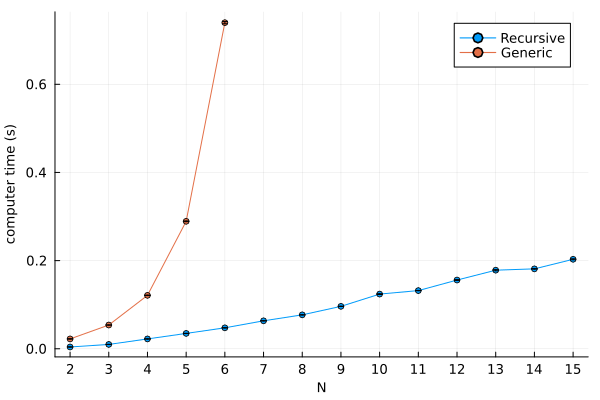

In [9]:
pl = plot(Ns, t_rec_avg, m=:o, label="Recursive", yerr=t_rec_std)
plot!(pl, Ns, t_gen_avg, m=:o, label="Generic", yerr=t_gen_std)
plot(pl, ylabel="computer time (s)", xlabel="N", legend=:topright,
    xticks=Ns)

In [10]:
jldsave("plot_data/star_graph.jld2"; Ns, t_rec_avg, t_rec_std, t_gen_avg, t_gen_std);